In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv('Heart_Rate_Data.csv')

data.head()

,Time,Values
0,27-03-2022,69
1,28-03-2022,69
2,29-03-2022,68
3,30-03-2022,67
4,31-03-2022,67


In [6]:
data['Time'] = pd.to_datetime(data['Time'],dayfirst=True)

In [7]:
data.set_index('Time',inplace=True)

In [ ]:
data

,Values
Time,
2022-03-27,69
2022-03-28,69
2022-03-29,68
2022-03-30,67
2022-03-31,67
...,...
2025-03-27,112
2025-03-28,118
2025-03-29,111


Now, we are going to train a Machine Learning model for forecasting. Since there are no independent features, we add some features like month, previous lags, rolling means, etc.

In [13]:
data['month'] = data.index.month
data['day'] = data.index.day
data['lag_1'] = data['Values'] - data['Values'].shift(1)
data['lag_4'] = data['Values'] - data['Values'].shift(4)
data['mean_4'] = data['Values'].rolling(window=4).mean()

In [19]:
data = data.iloc[:,[1,2,3,4,5,0]]
data

,month,day,lag_1,lag_4,mean_4,Values
Time,,,,,,
2022-03-27,3,27,NaN,NaN,NaN,69
2022-03-28,3,28,0.0,NaN,NaN,69
2022-03-29,3,29,-1.0,NaN,NaN,68
2022-03-30,3,30,-1.0,NaN,68.25,67
2022-03-31,3,31,0.0,-2.0,67.75,67
...,...,...,...,...,...,...
2025-03-27,3,27,11.0,42.0,97.00,112
2025-03-28,3,28,6.0,44.0,108.00,118
2025-03-29,3,29,-7.0,10.0,110.50,111


In [20]:
data.dropna(inplace=True)
data

,month,day,lag_1,lag_4,mean_4,Values
Time,,,,,,
2022-03-31,3,31,0.0,-2.0,67.75,67
2022-04-01,4,1,7.0,5.0,69.00,74
2022-04-02,4,2,-2.0,4.0,70.00,72
2022-04-03,4,3,-6.0,-1.0,69.75,66
2022-04-04,4,4,0.0,-1.0,69.50,66
...,...,...,...,...,...,...
2025-03-27,3,27,11.0,42.0,97.00,112
2025-03-28,3,28,6.0,44.0,108.00,118
2025-03-29,3,29,-7.0,10.0,110.50,111


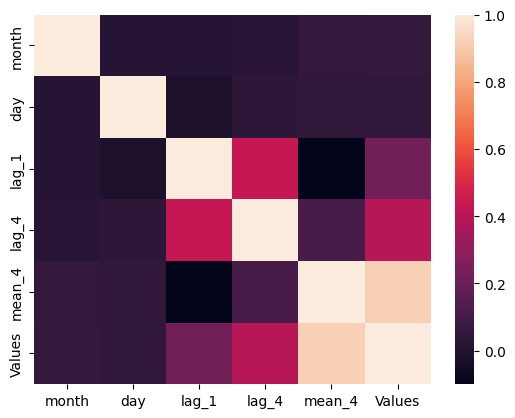

In [24]:
sns.heatmap(data.corr());

From the above heatmap, we can observe that most of features are less correlated with each other

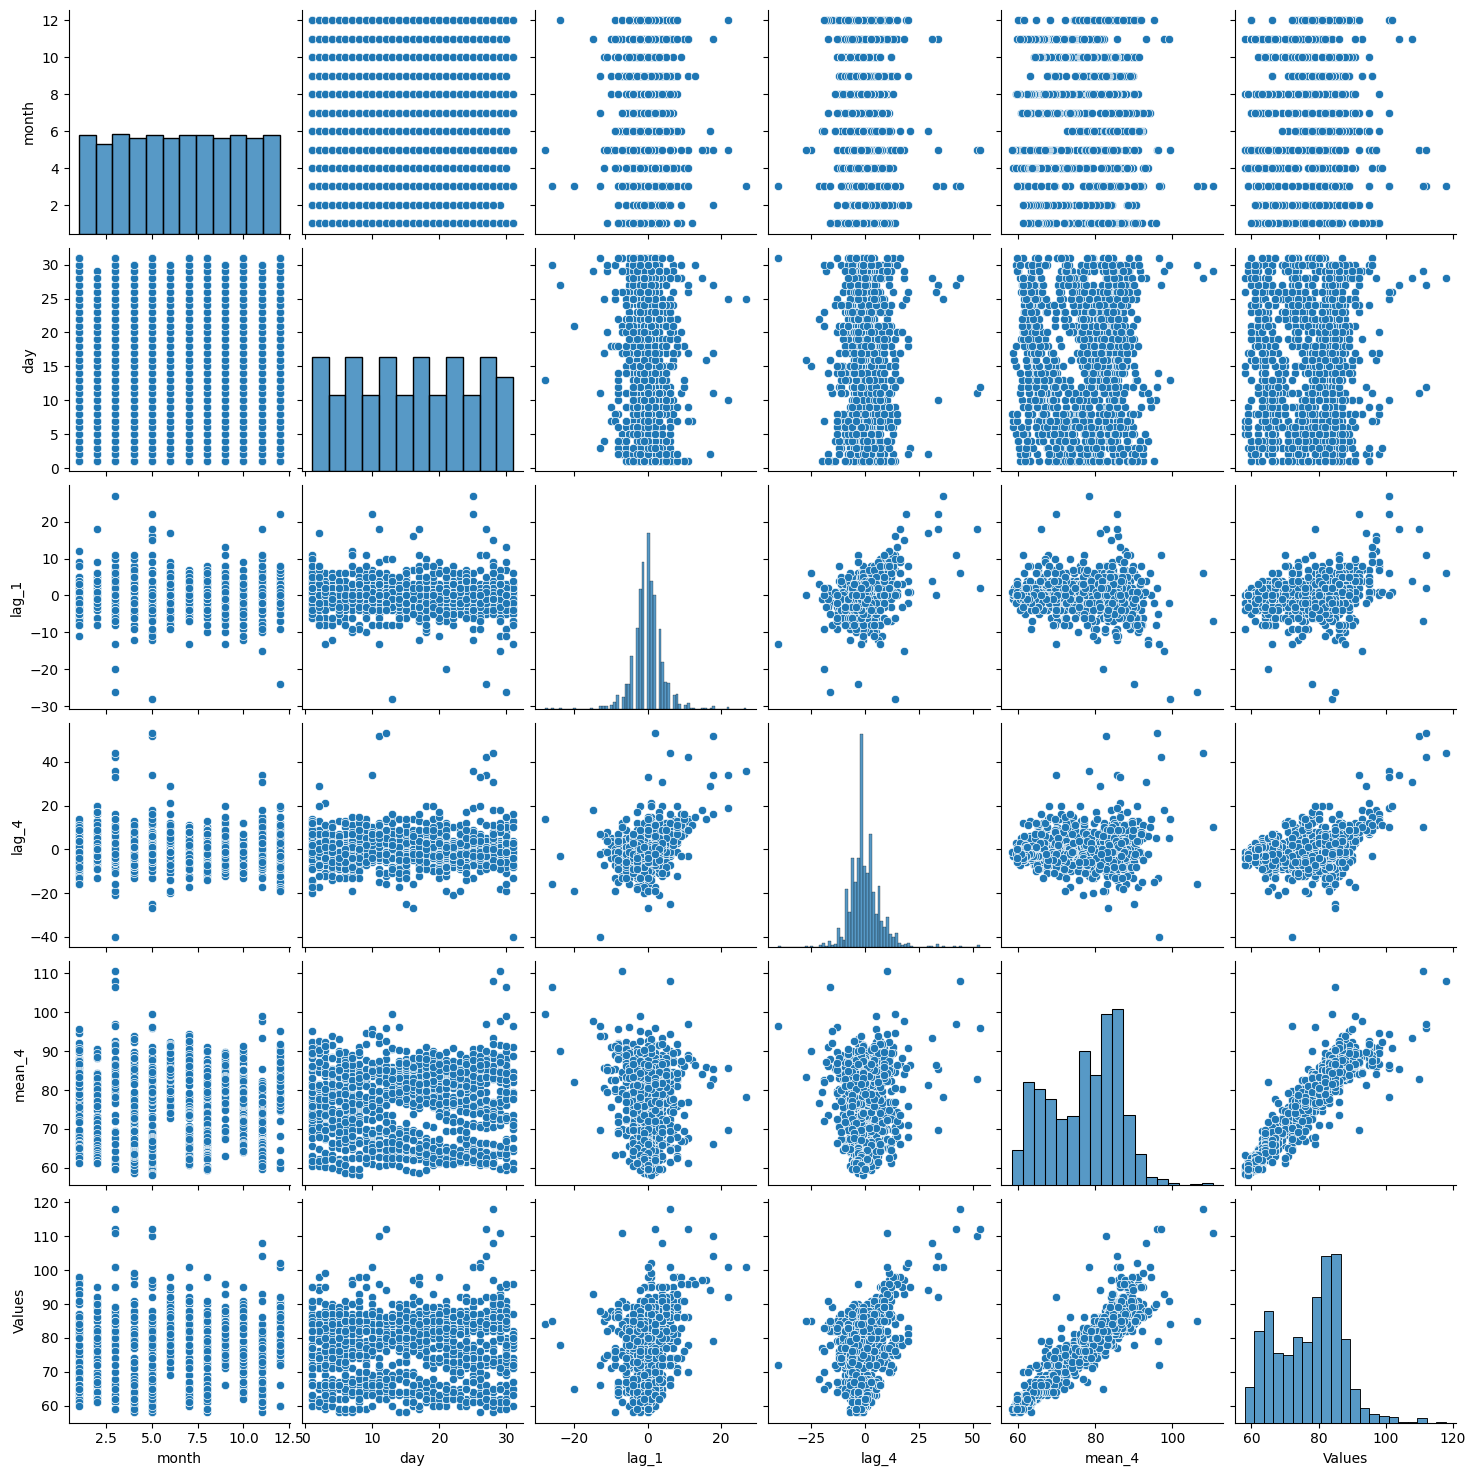

In [27]:
sns.pairplot(data=data);

To capture the complex relationship in the data, we use Random Forest Regressor.

In [37]:
train = data.iloc[:-5]
test = data.iloc[-5:]

X_train = train.drop(columns='Values').values
y_train = train['Values'].values

X_test = test.drop(columns='Values').values
y_test = test['Values'].values

In [39]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train,y_train)

RandomForestRegressor()

In [46]:
train.shape[1]

6

In [50]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test,model.predict(X_test))

n = train.shape[0]
f = train.shape[1]-1
adjusted_r2 = 1-(((1-r2)*(n-f))/(n-f-1))

print(r2)
print(adjusted_r2)

0.590663223140496
0.5902863016148427


R-squared of 0.59 implies that the model is performing very poor. So we perform hyperparameter tuning of the model and improve accuracy

In [51]:
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

model = RandomForestRegressor()
ts = TimeSeriesSplit(5)

grid_search = GridSearchCV(estimator=model,param_grid=param_grid,cv=ts,scoring='neg_mean_squared_error',n_jobs=-1)

grid_search.fit(data.drop(columns='Values').values,data['Values'].values)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [63]:
grid_search.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [53]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

r2 = r2_score(y_test,y_pred)

print(r2)

0.9471395097670924


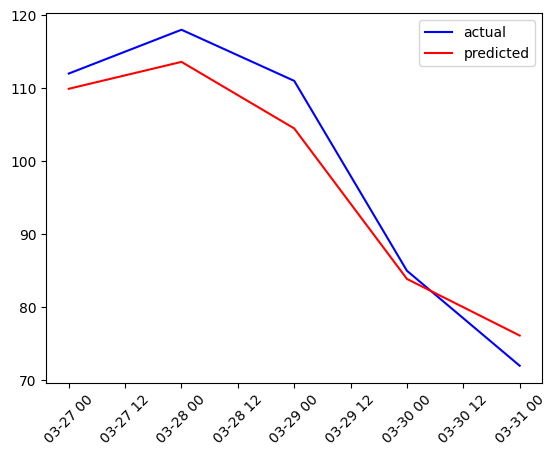

In [71]:
plt.plot(test.index,test['Values'],color='b',label='actual')
plt.plot(test.index,y_pred,color='r',label='predicted')
plt.legend()
plt.xticks(rotation=45);

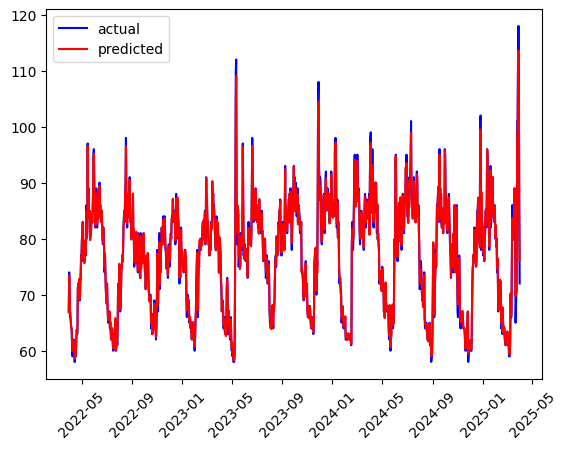

In [72]:
plt.plot(data.index,data['Values'],color='b',label='actual')
plt.plot(data.index,best_model.predict(data.drop(columns='Values').values),color='r',label='predicted')
plt.legend()
plt.xticks(rotation=45);